In [1]:
# # check GPU
# !nvidia-smi

In [2]:
# # pulls repo to colab
# !git clone https://github.com/char-tan/mode_connectivity.git

# # checkout specific branch if needed
# !cd mode_connectivity; git checkout geodesics

In [3]:
# allows you to change the .py files and have the imports updated
%load_ext autoreload
%autoreload 2

In [4]:
import sys, os
SCRIPT_DIR = os.path.dirname(os.path.abspath('.'))
sys.path.append(os.path.dirname(SCRIPT_DIR))

# sys.path.append("mode_connectivity") # run for colab

sys.path.append("../mode_connectivity") # run in vscode

In [9]:
!pip install torch
!pip install tqdm


In [5]:
import torch
from torchvision import transforms, datasets
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

from mode_connectivity.utils import weight_matching, data, training_utils, plot, utils
from mode_connectivity.training_config import *
from mode_connectivity.lmc import *
from mode_connectivity.training import *

from mode_connectivity.models.mlp import MLP

# from google.colab import files

/opt/anaconda3/envs/todl_final/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


# Training MLP models

In [16]:
# training_config = MLP_MNIST_DEFAULT
# training_config.epochs = 5
# training_config.seed = 7

# # train model a
# # model_a_noisy = train_model(*setup_train(training_config, additional_train_transforms = [AddGaussianNoise(0., 0.1)]), verbose = 1)
# model_a = train_model(*setup_train(training_config), verbose = 1)
# torch.save(model_a.state_dict(), 'mlp_mnist_model_a.pt')

# # change seed to get different model
# training_config.seed = 42

# # train model b
# # model_b_noisy = train_model(*setup_train(training_config, additional_train_transforms = [AddGaussianNoise(0., 0.1)]), verbose = 1)
# model_b = train_model(*setup_train(training_config), verbose = 1)
# torch.save(model_b.state_dict(), 'mlp_mnist_model_b.pt')  

In [ ]:
# # call this on googl colab to download files to local repo
# files.download('model_a_noisy_0.1.pt')
# files.download('model_b_noisy_0.1.pt')

# LMC in param space

In [17]:
# n_points = 25
# (
#     permuted_params,
#     train_acc_naive,
#     test_acc_naive,
#     train_acc_perm,
#     test_acc_perm,
# ) = linear_mode_connect(
#     MLP, "mlp_mnist_model_a.pt", "mlp_mnist_model_b.pt", "mnist", n_points=n_points, verbose=1
# )
# torch.save(permuted_params, 'mlp_mnist_model_pb.pt') 
# # files.download('mlp_mnist_model_pb.pt') 

In [7]:
# # First we do the basic linear interpolation plot
# lambdas = torch.linspace(0, 1, steps=n_points)
# plot.plot_interp_metric("accuracy", lambdas, train_acc_naive, test_acc_naive, train_acc_perm, test_acc_perm)

# Geodesic MC in functional space

In [8]:
from mode_connectivity.geodesic_opt import optimise_for_geodesic, metric_path_length
from mode_connectivity.utils import metrics

In [9]:
device, device_kwargs = get_device()

In [10]:
print(device, device_kwargs)

mps {}


In [13]:
# from torch.utils.data import DataLoader, ConcatDataset

# mnist_dataset = ConcatDataset([trainset, testset])

# all_mnist_dl = DataLoader(dataset = mnist_dataset, batch_size=mnist_dataset.__len__())

# all_mnist_images, all_mnist_lables = next(iter(all_mnist_dl))

In [24]:
# all_mnist_images = all_mnist_images.to(device)

# print(all_mnist_images.shape,all_mnist_images.device)

torch.Size([70000, 1, 28, 28]) cuda:0


In [15]:
# load in model state_dicts
# model_file_path = 'mode_connectivity/model_files/' # use this path in colab
model_file_path = '../model_files/'

# model_a, model_b, model_pb = (MLP(), MLP(), MLP())
# utils.load_checkpoint(model_a, model_file_path + "mlp_mnist_model_a.pt", device)
# utils.load_checkpoint(model_b, model_file_path + "mlp_mnist_model_b.pt", device)
# utils.load_checkpoint(model_pb, model_file_path + "mlp_mnist_model_pb.pt", device)

weights_a = torch.load(model_file_path + "mlp_mnist_model_a.pt", map_location=device)
weights_b = torch.load(model_file_path + "mlp_mnist_model_b.pt", map_location=device)
weights_pb = torch.load(model_file_path + "mlp_mnist_model_pb.pt", map_location=device)

In [16]:
train_loader, test_loader = data.get_data_loaders(
    dataset="mnist", train_kwargs={"batch_size":512}, test_kwargs={"batch_size":512}
)

In [17]:
n_points = 20
opt_weights, losses, euclid_dists = optimise_for_geodesic(
        MLP, weights_a, weights_b,
        n = n_points,
        loss_metric = metrics.JSD_loss,
        dataloader = train_loader,
        max_iterations = 99,
        learning_rate = .1,
        return_losses = True,
        return_euclid_dist= True,
    )

Optimising geodesic ...


100%|██████████| 99/99 [01:03<00:00,  1.57it/s]


In [18]:
loss_plots = [loss.detach().cpu() for loss in losses]
sq_euclid_dist_plots = [euclid_dist.detach().cpu() for euclid_dist in euclid_dists]

Text(0, 0.5, 'path action via (squared) euclid dist')

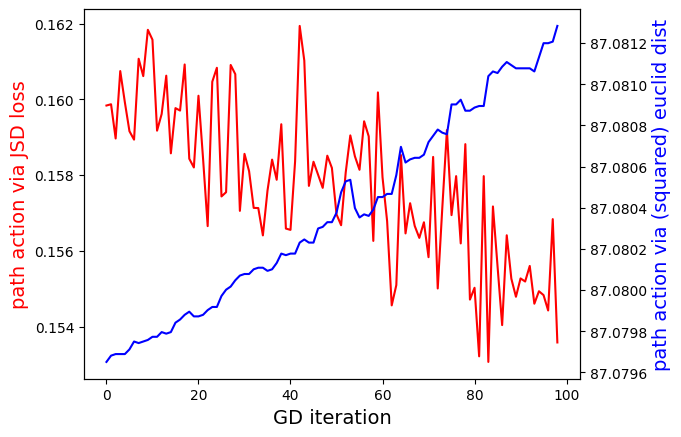

In [20]:
fig, ax = plt.subplots()

loss_type = 'JSD loss'

ax.plot(loss_plots, color = 'red')
ax.set_xlabel('GD iteration', fontsize = 14)
ax.set_ylabel('path action via ' + loss_type, color = 'red', fontsize = 14)

ax2=ax.twinx()
ax2.plot(sq_euclid_dist_plots, color = 'blue')
ax2.set_ylabel('path action via (squared) euclid dist', color = 'blue', fontsize = 14)

In [41]:
# torch.save(opt_weights, 'opt_weights.pt')
# files.download('opt_weights.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
# torch.save(losses, 'losses.pt')
# files.download('losses.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>